# Diccionario Español - Inglés

El objetivo de este notebook es crear un diccionario Español - Inglés 

### Librerías

In [10]:
import numpy as np
import gensim
import subprocess
import os
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import wordcloud
from IPython.core.pylabtools import figsize
figsize(50, 50)
from sklearn.manifold import TSNE
import json
from collections import Counter
from itertools import chain

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
import string
!pip install unidecode
import unidecode # para quitar los acentos en caso de que haya en español
import re
from numpy import array, argmax, random, take
import pandas as pd
%tensorflow_version 1.x
import tensorflow
print(tensorflow.__version__)
from keras.utils import get_file
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Bidirectional, RepeatVector, TimeDistributed, GRU, CuDNNLSTM, Bidirectional, Dropout
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_colwidth', 200)

TensorFlow is already loaded. Please restart the runtime to change versions.
2.2.0-rc3


Los datos es un archivo de texto de parejas de frases en Inglés y Español. Primero leemos los datos del archivo

In [ ]:
# function to read raw text file
def read_text(filename):
    # open the file
    file = open(filename, mode='rt', encoding='utf-8')
    # read all text
    text = file.read()
    file.close()
    return text

Separamos el texto en pares usando el salto de línea \n y separamos los pares en frases en Inglés y Español con el tabulador \t

In [ ]:
# split a text into sentences
def to_lines(text):
    sents = text.strip().split('\n')
    sents = [i.split('\t') for i in sents]
    return sents

Cargamos los datos desde Drive

In [14]:
from google.colab import drive
drive.mount('/content/drive')

# Navigate to code directory
%cd /content/drive/My Drive/DeliverableTEXT

# List project directory contents
!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/DeliverableTEXT
Deliverable_TEXT_MachineTranslation_ES_EN.ipynb  model.h1_loss2
deu-eng						 model.h1_RELU
generated					 model.h1_sigmoid
MachineTranslation_ES_EN.ipynb			 model.h1_simpler
model.h1_final					 spa-eng


In [15]:
data = read_text("./spa-eng/spa.txt")
clean_data = [i[0:2] for i in to_lines(data)] # Leemos solo las dos primeras columnas
esp_eng = array(clean_data)
len(esp_eng)

122936

Los datos contienen 122936 pares. Utilizaremos todos ellos para el entrenamiento del modelo, aunque si quisiesemos reducir el tiempo de entrenamiento podríamos utilizar menos datos

In [ ]:
#esp_eng = esp_eng[:50000,:] # Si quisiesemos un dataset reducido

### Text Pre-Processing

#### Text Cleaning

Echamos un vistazo a los datos y después decidimos que procesos seguir

In [17]:
esp_eng

array([['Go.', 'Ve.'],
       ['Go.', 'Vete.'],
       ['Go.', 'Vaya.'],
       ...,
       ['Since there are usually multiple websites on any given topic, I usually just click the back button when I arrive on any webpage that has pop-up advertising. I just go to the next page found by Google and hope for something less irritating.',
        'Como suele haber varias páginas web sobre cualquier tema, normalmente sólo le doy al botón de retroceso cuando entro en una página web que tiene anuncios en ventanas emergentes. Simplemente voy a la siguiente página encontrada por Google y espero encontrar algo menos irritante.'],
       ['If you want to sound like a native speaker, you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until they can play it correctly and at the desired tempo.',
        'Si quieres sonar como un hablante nativo, debes estar dispuesto a practicar diciendo la misma frase una y

Quitamos los signos de puntuación y lo pasamos a minúscula.

In [ ]:
# Remove punctuation
esp_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in esp_eng[:,0]] # En las frases en ingles
esp_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in esp_eng[:,1]] # En las frases en español

In [19]:
esp_eng

array([['Go', 'Ve'],
       ['Go', 'Vete'],
       ['Go', 'Vaya'],
       ...,
       ['Since there are usually multiple websites on any given topic I usually just click the back button when I arrive on any webpage that has popup advertising I just go to the next page found by Google and hope for something less irritating',
        'Como suele haber varias páginas web sobre cualquier tema normalmente sólo le doy al botón de retroceso cuando entro en una página web que tiene anuncios en ventanas emergentes Simplemente voy a la siguiente página encontrada por Google y espero encontrar algo menos irritante'],
       ['If you want to sound like a native speaker you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until they can play it correctly and at the desired tempo',
        'Si quieres sonar como un hablante nativo debes estar dispuesto a practicar diciendo la misma frase una y otra vez de la 

In [ ]:
# convert to lowercase and remove accents
for i in range(len(esp_eng)):
    esp_eng[i,0] = unidecode.unidecode(esp_eng[i,0].lower())
    esp_eng[i,1] = unidecode.unidecode(esp_eng[i,1].lower())

In [21]:
esp_eng

array([['go', 've'],
       ['go', 'vete'],
       ['go', 'vaya'],
       ...,
       ['since there are usually multiple websites on any given topic i usually just click the back button when i arrive on any webpage that has popup advertising i just go to the next page found by google and hope for something less irritating',
        'como suele haber varias paginas web sobre cualquier tema normalmente solo le doy al boton de retroceso cuando entro en una pagina web que tiene anuncios en ventanas emergentes simplemente voy a la siguiente pagina encontrada por google y espero encontrar algo menos irritante'],
       ['if you want to sound like a native speaker you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until they can play it correctly and at the desired tempo',
        'si quieres sonar como un hablante nativo debes estar dispuesto a practicar diciendo la misma frase una y otra vez de la 

# Exploración de los datos

In [ ]:
words_in_str = [i.replace("\n","").replace("!","").replace("?","").split() for i in esp_eng[:,0:2].flatten()]

In [ ]:
all_words = [ii for i in words_in_str for ii in i]

In [ ]:
tokens = [i for i in all_words if (len(i)>1) and i not in stopwords.words('spanish')]
tokens2 = [i for i in tokens if (len(i)>1) and i not in stopwords.words('english')]

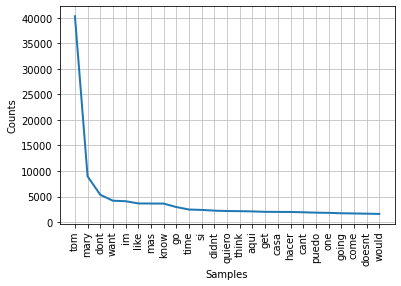

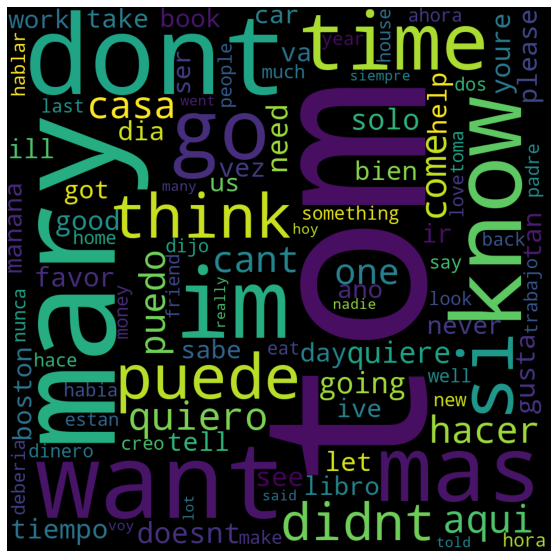

In [25]:
nltk.FreqDist.plot(nltk.FreqDist(tokens2), 25)

wc2 = wordcloud.WordCloud(
    width=1000, 
    height=1000, 
    max_words=100,
    collocations=False
).generate(text=(' '.join(tokens2)))

get_ipython().run_line_magic('matplotlib', 'inline')
plt.figure(figsize=[10,10])
plt.imshow(wc2)
plt.axis("off");

Como se puede ver, las palabras más comunes en las traducciones suelen ser o nombres propios o verbos comunes como querer pensar, poder, venir, saber...

### Sacar las palabras más complicadas de las traducciones

Podemos intentar ver las palabras más raras de las traducciones mediante técnicas de words embeddings

In [ ]:
MODEL = 'GoogleNews-vectors-negative300.bin'
path= get_file(MODEL + '.gz','https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz')
#path = get_file(MODEL + '.gz', 'https://deeplearning4jblob.blob.core.windows.net/resources/wordvectors/%s.gz' % MODEL)
if not os.path.isdir('generated'):
    os.mkdir('generated')

unzipped = os.path.join('generated', MODEL)
if not os.path.isfile(unzipped):
    with open(unzipped, 'wb') as fout:
        zcat = subprocess.Popen(['zcat'],
                          stdin=open(path),
                          stdout=fout
                         )
        zcat.wait()

In [27]:
model = gensim.models.KeyedVectors.load_word2vec_format(unzipped, binary=True)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [28]:
item_vectors = [(item, model[item]) 
                    for item in list(set(tokens2)) # Hacemos un listado de las palabras únicas
                    if item in model] # lo que hacemos es encontrar las representaciones de las palabras en nuestro modelo
len(item_vectors)

15279

Si usamos t-SNE veríamos las palabras mas raras de las traducciones como aquellas que se encuentren más alejadas del resto

In [30]:
vectors = np.asarray([x[1] for x in item_vectors])
lengths = np.linalg.norm(vectors, axis=1)
norm_vectors = (vectors.T / lengths).T

tsne = TSNE(n_components=2, perplexity=10, verbose=2).fit_transform(norm_vectors)

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 15279 samples in 0.510s...
[t-SNE] Computed neighbors for 15279 samples in 139.577s...
[t-SNE] Computed conditional probabilities for sample 1000 / 15279
[t-SNE] Computed conditional probabilities for sample 2000 / 15279
[t-SNE] Computed conditional probabilities for sample 3000 / 15279
[t-SNE] Computed conditional probabilities for sample 4000 / 15279
[t-SNE] Computed conditional probabilities for sample 5000 / 15279
[t-SNE] Computed conditional probabilities for sample 6000 / 15279
[t-SNE] Computed conditional probabilities for sample 7000 / 15279
[t-SNE] Computed conditional probabilities for sample 8000 / 15279
[t-SNE] Computed conditional probabilities for sample 9000 / 15279
[t-SNE] Computed conditional probabilities for sample 10000 / 15279
[t-SNE] Computed conditional probabilities for sample 11000 / 15279
[t-SNE] Computed conditional probabilities for sample 12000 / 15279
[t-SNE] Computed conditional probabilities for s

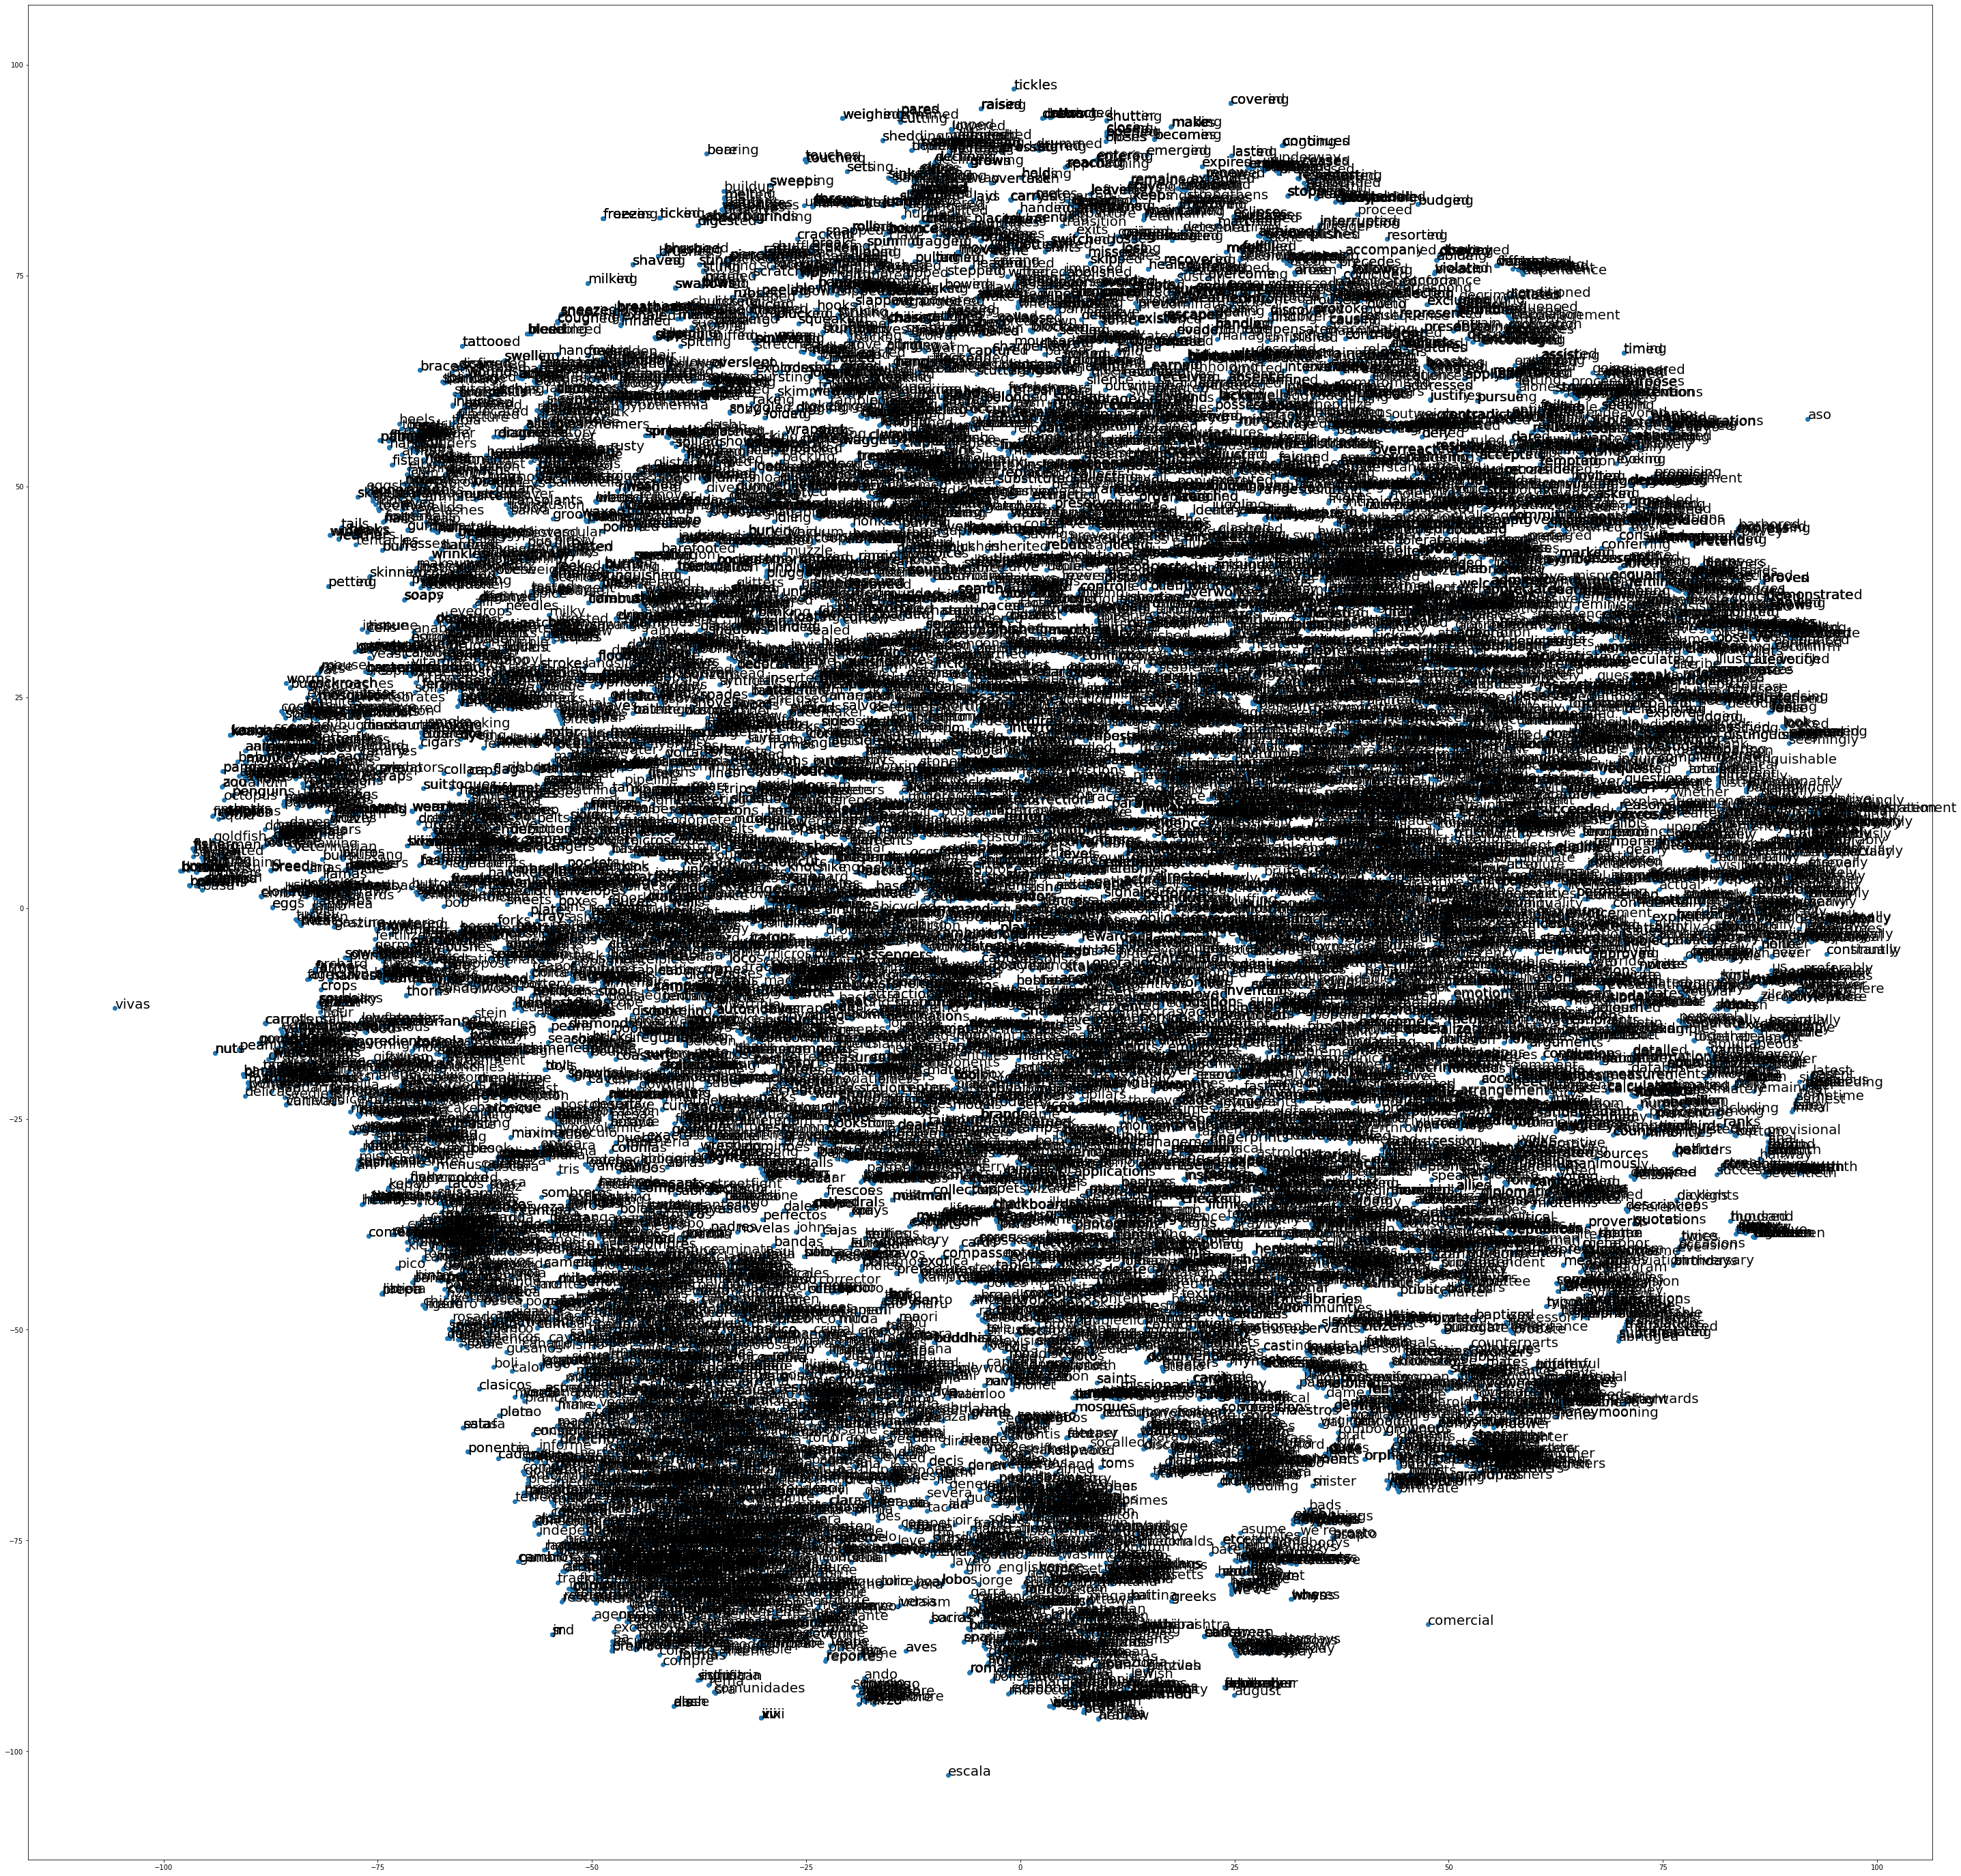

<Figure size 3600x3600 with 0 Axes>

In [36]:
x=tsne[:,0]
y=tsne[:,1]

fig, ax = plt.subplots()
ax.scatter(x, y)

for item, x1, y1 in zip(item_vectors, x, y):
    ax.annotate(item[0], (x1, y1), size=20)

plt.figure(figsize=[50,50])
plt.show()

Podemos ver que algunas de las palabras más complejas pueden ser vivas, escala, comercial y aso. Todas ellas son palabras complejas o bien porque se tratan de palabras que se utilizan en contextos específicos o bien porque son formas verbales avanzadas (imperativos).

#### Text to Sequence Conversion

Para entrenar el modelo de Seq2Seq convertiremos la salida y la entrada en secuencias de enteros. Antes de eso visualizaremos la longitud de las frases y capturaremos estas longitudes en dos arrays distintas.

In [ ]:
# populate the lists with sentence lengths
eng_l = [len(i.split()) for i in esp_eng[:,0]]
esp_l = [len(i.split()) for i in esp_eng[:,1]]

In [ ]:
length_df = pd.DataFrame({'eng':eng_l, 'esp':esp_l})
print(length_df)
print(max(length_df.eng))
print(max(length_df.esp))

max_length = max(max(length_df.eng), max(length_df.esp)) # cogemos la maxima longitud automaticamente
print(max_length)

        eng  esp
0         1    1
1         1    1
2         1    1
3         1    1
4         1    1
...     ...  ...
122931   34   42
122932   34   35
122933   43   44
122934   47   49
122935   47   53

[122936 rows x 2 columns]
47
53
53


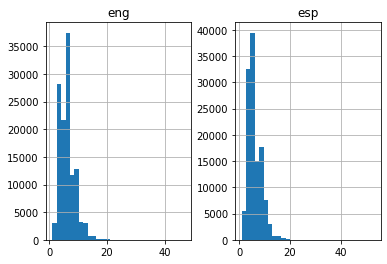

In [ ]:
length_df.hist(bins = 30)
plt.show()

La longitud maxima de las frases en español es 12 y en las de inglés es 8.

Vectorizamos los datos usando la clase Tokenizer() de Keras. Esto transformará nuestras frases en secuencias de enterior. Después usaremos padding para que todas tengan la misma longitud.

In [ ]:
# function to build a tokenizer
def tokenization(lines):
    tokenizer = Tokenizer(char_level = False) # editamos la funcion de tokenizacion
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [ ]:
# prepare english tokenizer
eng_tokenizer = tokenization(esp_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = max_length # max length (deberia ser 8 pero lo fijamos a la maxima de los dos idiomas para coger todo)
print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 13724


In [ ]:
# prepare spanish tokenizer
esp_tokenizer = tokenization(esp_eng[:, 1])
esp_vocab_size = len(esp_tokenizer.word_index) + 1

esp_length = eng_length # la longitud de la entrada es la misma que la de la salida
print('Spanish Vocabulary Size: %d' % esp_vocab_size)

Spanish Vocabulary Size: 25424


In [ ]:
print(str(esp_tokenizer.word_counts)[0:145])

OrderedDict([('ve', 233), ('vete', 51), ('vaya', 176), ('vayase', 8), ('hola', 31), ('corre', 41), ('corran', 4), ('corra', 3), ('corred', 4), ('


La siguiente función nos prepara las secuencias. También aplicará padding para ajustar todas las frases a la misma longitud.

In [ ]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
    # integer encode sequences
    seq = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values
    seq = pad_sequences(seq, maxlen=length, padding='post')
    print(seq)
    print(len(seq))
    return seq

### Model Building

Dividimos los datos en entrenamiento y test

In [ ]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(esp_eng, test_size=0.2, random_state = 12)

Ahora hacemos encoding a las frases. Hacemos encode a las frases en español como las secuencias de entrada y las de inglés como las secuencias de salida, tanto para entrenamiento como para test.

In [ ]:
# prepare training data
trainX = encode_sequences(esp_tokenizer, esp_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

[[   98    52    28 ...     0     0     0]
 [    7  1112 14259 ...     0     0     0]
 [    4   115  4129 ...     0     0     0]
 ...
 [   57   298  2312 ...     0     0     0]
 [    4   263   786 ...     0     0     0]
 [   17   118  1784 ...     0     0     0]]
98348
[[  44   22   86 ...    0    0    0]
 [8197 1181    7 ...    0    0    0]
 [   2   56   31 ...    0    0    0]
 ...
 [  74  470  836 ...    0    0    0]
 [   2  219   68 ...    0    0    0]
 [  17  156 1081 ...    0    0    0]]
98348


In [ ]:
print(trainX.shape)
print(trainY.shape)

(98348, 53)
(98348, 53)


In [ ]:
# prepare validation data
testX = encode_sequences(esp_tokenizer, esp_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

[[  21   54 4535 ...    0    0    0]
 [  12  159  232 ...    0    0    0]
 [   9  190    1 ...    0    0    0]
 ...
 [   3  126   16 ...    0    0    0]
 [  22  244   15 ...    0    0    0]
 [ 498  905  107 ...    0    0    0]]
24588
[[  21   42 3163 ...    0    0    0]
 [ 161   35    3 ...    0    0    0]
 [   8    7  224 ...    0    0    0]
 ...
 [   8   54    6 ...    0    0    0]
 [  21  150  532 ...    0    0    0]
 [   2  291    2 ...    0    0    0]]
24588


In [ ]:
print(testX.shape)
print(testY.shape)

(24588, 53)
(24588, 53)


Ahora se define la arquitectura del modelo Seq2Seq. Usamos una capa Embedding y una capa de LSTM como encoder y otra LSTM y una Dense como decoder.

In [ ]:
# build NMT model
def build_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(LSTM(units))
    model.add(RepeatVector(out_timesteps))    
    model.add(LSTM(units, return_sequences=True))
    model.add(Dense(out_vocab, activation='softmax'))
    return model

Details about the RepeatVector :  https://campus.datacamp.com/courses/machine-translation-in-python/implementing-an-encoder-decoder-model-with-keras?ex=6

Usamos un optimizador RMSprop para el modelo ya que usualmente es una buena elección para redes neuronales recurrentes.

In [ ]:
print(esp_vocab_size)
print(eng_vocab_size)
print(esp_length)
print(eng_length)

25424
13724
53
53


In [ ]:
model1 = build_model(esp_vocab_size, eng_vocab_size, esp_length, eng_length, 512)
rms = optimizers.RMSprop(lr=0.001)
model1.compile(optimizer=rms, loss='sparse_categorical_crossentropy',
              metrics = ['accuracy'])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Usamos __'sparse_categorical_crossentropy'__ como función de perdida porque nos permite usar la secuencia de salida como tal en lugar del formato one hot encoded. Hacer One Hot encoding en la secuencia de salida con un vocabulario tan grande seguramente consuma toda la memoria de nuestro sistema.

Entrenaremos el modelo con 30 epoch y un batch size de 512, aunque estos hiperparametros se pueden modificar. Usaremos __ModelCheckpoint()__ para guardar el mejor modelo con mejor perdida en validación.

In [ ]:
filename = 'model.h1_loss2'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history1 = model1.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1), 
          epochs=10, batch_size=128, 
          validation_split = 0.2,
          callbacks=[checkpoint], verbose=1)


Train on 78678 samples, validate on 19670 samples
Epoch 1/10
78678/78678 [==============================] - 434s 6ms/step - loss: 0.8160 - accuracy: 0.8880 - val_loss: 0.6974 - val_accuracy: 0.8951

Epoch 00001: val_loss improved from inf to 0.69736, saving model to model.h1_loss2
Epoch 2/10
78678/78678 [==============================] - 433s 5ms/step - loss: 0.6547 - accuracy: 0.9000 - val_loss: 0.6196 - val_accuracy: 0.9043

Epoch 00002: val_loss improved from 0.69736 to 0.61964, saving model to model.h1_loss2
Epoch 3/10
78678/78678 [==============================] - 435s 6ms/step - loss: 0.5695 - accuracy: 0.9092 - val_loss: 0.5507 - val_accuracy: 0.9116

Epoch 00003: val_loss improved from 0.61964 to 0.55075, saving model to model.h1_loss2
Epoch 4/10
78678/78678 [==============================] - 437s 6ms/step - loss: 0.5027 - accuracy: 0.9160 - val_loss: 0.5010 - val_accuracy: 0.9166

Epoch 00004: val_loss improved from 0.55075 to 0.50104, saving model to model.h1_loss2
Epoch 5/1

Tenemos una precisión en validación del 92,7%

Comparamos la perdida en entrenamiento y validación.

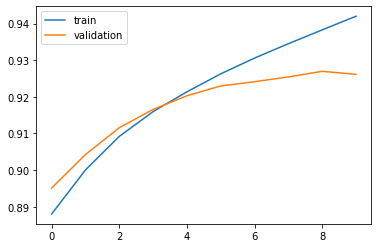

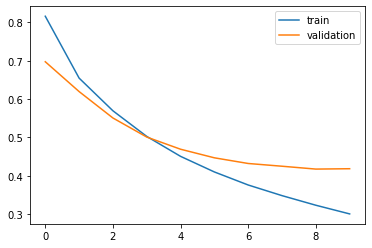

In [ ]:
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.legend(['train','validation'])
plt.show()

plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

### Make Predictions

Cargamos el modelo para hacer predicciones

In [ ]:
model1 = load_model('model.h1_loss2')
preds = model1.predict_classes(testX[:1000,:].reshape((1000,testX.shape[1])))
#preds = model1.predict_classes(testX.reshape((testX.shape[0],testX.shape[1]))) # Muy costoso computacionalmente

In [ ]:
def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return None

In [ ]:
# convert predictions into text (English)
preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], eng_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
             
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t)            
        
    preds_text.append(' '.join(temp))

In [ ]:
pred_df1 = pd.DataFrame({'actual' : test[:1000,0], 'predicted' : preds_text})

In [ ]:
pd.set_option('display.max_colwidth', 200)

In [ ]:
pred_df1.head(15)

actual                                                                     predicted
0               she has forgiven him for everything          she has everything                                                  
1                         id like to have an answer       id like to have a answer                                               
2                                he is sure to come        it is sure he will come                                               
3   we discovered relics of an ancient civilization               we will into a                                                 
4                                       i am single                  im single                                                   
5           i was very tired so i went to bed early   i was very tired so i went bed                                             
6                 he is able to speak ten languages  he is able to speak  languages                                              
7                      you should have come earlier      you should have get  soon                                               
8                         i remember telling you so         i remember this like                                                 
9                              do you need the book            you need  the book                                                
10                    did you buy a washing machine         did you buy a machine                                                
11                       tom is very crafty isnt he              tom is a person                                                 
12                        how far is it to new york            how far is you new                                                
13                   may i go to the movies tonight  can i go to the movies tonight                                              
14  we have known each other since we were children      we know each the other  we

In [ ]:
pred_df1.tail(15)

actual                                                                      predicted
985                              is tom trying to ruin our evening             tom will be  to tom                                               
986                  he has lived here since he was five years old     he has here since  was years                                              
987                                                   you look hot                  you seem to                                                  
988                                look there goes a shooting star        look a beautiful truck                                                 
989                                i will show you around the city    ill show you around the town                                               
990                                            tom waited his turn         tom waited up his turn                                                
991                            i have to take a bus to go anywhere           i need to take a to go                                              
992                               i come here every fourth of july              i come here  four                                                
993                          i went to the supermarket with my mom    i went to the airport with my                                              
994                                         is the bank open today                is the  street                                                 
995                           what museums would you like to visit         what would you  want to                                               
996                              the dynamite went off with a bang              he wheres with  a                                                
997                      tom said you would ask a lot of questions  tom said you do  some  questions                                             
998                                      do you know when to do it        do you know when to do it                                              
999  an immense monument was erected in honor of the noble patriot   a great was  lived in the  of the

In [ ]:
pred_df1.sample(15)

actual                                                                           predicted
979      did you see how big their house is  did you see what idea house tom house                                             
870                           she loves tom                     she wants tom                                                  
346                          i have no home                      i dont have a                                                 
301    who told you i was talking about you              who told you  was  about                                              
355                          whats its name                      what is name                                                  
738      that is the worst thing you can do             thats the worst you  can                                               
467                  i dont feel well today                  i dont feel  today                                                
305      i enjoy the time we spend together            i remember the time  went                                               
569  tom seemed to be somewhat disappointed                tom seems to be  cold                                               
393      i thought we could walk home today    i thought we could go to next today                                             
371                       why didnt you eat                  why didnt you eat                                                 
492               women age faster than men               women men women than                                                 
252   dont tell tom about what we did today       dont tell what tom should done                                               
270      pass me the butter will you please                  please fill the a                                                 
761                       i am 19 years old                     i am years old

### Modelo más simple

Usando un GRU en lugar de LTSM

In [ ]:
# build NMT model
def build_simpler_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(GRU(units)) # GRU instead of LSTM
    model.add(RepeatVector(out_timesteps))    
    model.add(GRU(units, return_sequences=True))
    model.add(Dense(out_vocab, activation='softmax'))
    return model

In [ ]:
model2 = build_simpler_model(esp_vocab_size, eng_vocab_size, esp_length, eng_length, 512)
rms = optimizers.RMSprop(lr=0.001)
model2.compile(optimizer=rms, loss='sparse_categorical_crossentropy',
              metrics = ['accuracy'])

Entrenaremos el modelo.

In [ ]:
filename = 'model.h1_simpler'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history2 = model2.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1), 
          epochs=10, batch_size=128, 
          validation_split = 0.2,
          callbacks=[checkpoint], verbose=1)


Train on 78678 samples, validate on 19670 samples
Epoch 1/10
78678/78678 [==============================] - 410s 5ms/step - loss: 0.8188 - accuracy: 0.8883 - val_loss: 0.6924 - val_accuracy: 0.8962

Epoch 00001: val_loss improved from inf to 0.69238, saving model to model.h1_simpler
Epoch 2/10
78678/78678 [==============================] - 407s 5ms/step - loss: 0.6326 - accuracy: 0.9024 - val_loss: 0.5855 - val_accuracy: 0.9081

Epoch 00002: val_loss improved from 0.69238 to 0.58549, saving model to model.h1_simpler
Epoch 3/10
78678/78678 [==============================] - 410s 5ms/step - loss: 0.5377 - accuracy: 0.9125 - val_loss: 0.5199 - val_accuracy: 0.9148

Epoch 00003: val_loss improved from 0.58549 to 0.51994, saving model to model.h1_simpler
Epoch 4/10
78678/78678 [==============================] - 410s 5ms/step - loss: 0.4726 - accuracy: 0.9194 - val_loss: 0.4806 - val_accuracy: 0.9190

Epoch 00004: val_loss improved from 0.51994 to 0.48057, saving model to model.h1_simpler
E

Precisión en validación de 92,9%

Comparamos la perdida en entrenamiento y validación.

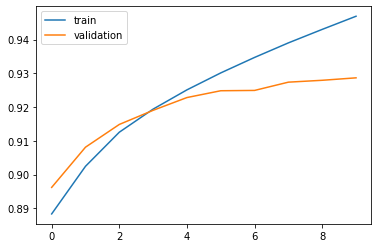

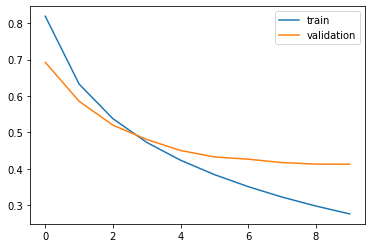

In [ ]:
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.legend(['train','validation'])
plt.show()

plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

Parece que este modelo tiene una actuación parecida al que utiliza LSTM, sin embargo parece que sobreentrena más, hay mas distancia entre la curva de entranamiento y validación.

### Make Predictions

Cargamos el modelo para hacer predicciones

In [ ]:
model2 = load_model('model.h1_simpler')
preds = model2.predict_classes(testX[:1000,:].reshape((1000,testX.shape[1])))

In [ ]:
# convert predictions into text (English)
preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], eng_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
             
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t)            
        
    preds_text.append(' '.join(temp))

In [ ]:
pred_df2 = pd.DataFrame({'actual' : test[:1000,0], 'predicted' : preds_text})

In [ ]:
pd.set_option('display.max_colwidth', 200)

In [ ]:
pred_df2.head(15)

actual                                                                                predicted
0               she has forgiven him for everything                     she has everything                                                  
1                         id like to have an answer                  id like to have a answer                                               
2                                he is sure to come                      its is what he  come                                               
3   we discovered relics of an ancient civilization                            we have a of                                                 
4                                       i am single                                  im a                                                   
5           i was very tired so i went to bed early            i was very tired of i went to bed                                            
6                 he is able to speak ten languages          he is able to speak ten languages                                              
7                      you should have come earlier                    you should have come                                                 
8                         i remember telling you so                            i hate that                                                  
9                              do you need the book                       you  need the book                                                
10                    did you buy a washing machine                    did you buy a washing                                                
11                       tom is very crafty isnt he                         tom is a person                                                 
12                        how far is it to new york                     how far is new of new                                               
13                   may i go to the movies tonight                    may i go to the movies                                               
14  we have known each other since we were children  we remember the other of other they we each

In [ ]:
pred_df2.tail(15)

actual                                                                          predicted
985                              is tom trying to ruin our evening         tom will be  to catch a again                                             
986                  he has lived here since he was five years old        he has here since that he was                                              
987                                                   you look hot               you seem surprised                                                  
988                                look there goes a shooting star                   look a  thought                                                 
989                                i will show you around the city            ill show you around the                                                
990                                            tom waited his turn               tom waited his turn                                                 
991                            i have to take a bus to go anywhere             i have to take to bus it                                              
992                               i come here every fourth of july                 i come every  four                                                
993                          i went to the supermarket with my mom            i went to the with  my and                                             
994                                         is the bank open today                     is the bus to                                                 
995                           what museums would you like to visit           what would do you like to                                               
996                              the dynamite went off with a bang                 he was like with a                                                
997                      tom said you would ask a lot of questions  tom said you would make a questions                                              
998                                      do you know when to do it            do you know when it do it                                              
999  an immense monument was erected in honor of the noble patriot   a english was  been in the in of know

In [ ]:
pred_df2.sample(15)

actual                                                                          predicted
149                       maybe theres something i can do                  if may have i  can                                               
536                                      my legs are sore                         my legs                                                   
526                                          you go first                        go first                                                   
576                          tom is going to try it again                tom will able it to                                                
429                            i dont know whats happened          i dont know what happened                                                
766                                 does anyone live here                  they lives here                                                  
934                                           nice timing                          i time                                                   
109                            tom doesnt want marys pity           tom didnt want the marys                                                
662                     how do you go to school every day            how do you go school  day                                              
105                              do you have school today                 do you have today                                                 
104  it was so hot that i thought i was going to pass out  i was so cold that i thought to  going                                           
450                  you have too many books on the shelf            you  have many books  the                                              
173        the dance had already started when i got there   he came arrived to the when  he came                                            
578                                     do you drink beer                 do you drink beer                                                 
711          let me give you a lift as far as the station           let i take to   station the

Las traducciones son mas o menos parecidas

### Modelo algo mas complejo, introducimos una GRU bidirectional RNN depués de las srgunda LTSM

Para que no sobreentrene introducimos una capa de Dropout de 20%. También probaremos cambiando la función de activación por una sigmoid

In [ ]:
# build NMT model
def build_sigmoid_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(LSTM(units))
    model.add(RepeatVector(out_timesteps))    
    model.add(LSTM(units))
    model.add(Bidirectional(GRU(units,return_sequences=True)))
    model.add(Dropout(0.2))
    model.add(Dense(out_vocab, activation='sigmoid')) # sigmoid en lugar de softmax
    return model

In [ ]:
model3 = build_sigmoid_model(esp_vocab_size, eng_vocab_size, esp_length, eng_length, 512)
rms = optimizers.RMSprop(lr=0.001)
model3.compile(optimizer=rms, loss='sparse_categorical_crossentropy',
              metrics = ['accuracy'])

Entrenaremos el modelo.

In [ ]:
filename = 'model.h1_sigmoid'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history3 = model3.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1), 
          epochs=10, batch_size=128, 
          validation_split = 0.2,
          callbacks=[checkpoint], verbose=1)

Train on 78678 samples, validate on 19670 samples
Epoch 1/10
78678/78678 [==============================] - 588s 7ms/step - loss: 0.8841 - accuracy: 0.8847 - val_loss: 0.6946 - val_accuracy: 0.8953

Epoch 00001: val_loss improved from inf to 0.69461, saving model to model.h1_sigmoid
Epoch 2/10
78678/78678 [==============================] - 587s 7ms/step - loss: 0.6438 - accuracy: 0.9004 - val_loss: 0.6003 - val_accuracy: 0.9052

Epoch 00002: val_loss improved from 0.69461 to 0.60027, saving model to model.h1_sigmoid
Epoch 3/10
78678/78678 [==============================] - 588s 7ms/step - loss: 0.5633 - accuracy: 0.9092 - val_loss: 0.5386 - val_accuracy: 0.9120

Epoch 00003: val_loss improved from 0.60027 to 0.53862, saving model to model.h1_sigmoid
Epoch 4/10
78678/78678 [==============================] - 585s 7ms/step - loss: 0.5032 - accuracy: 0.9156 - val_loss: 0.4946 - val_accuracy: 0.9168

Epoch 00004: val_loss improved from 0.53862 to 0.49461, saving model to model.h1_sigmoid
Ep

Precisión en validación de 92,7%

Comparamos la perdida en entrenamiento y validación.

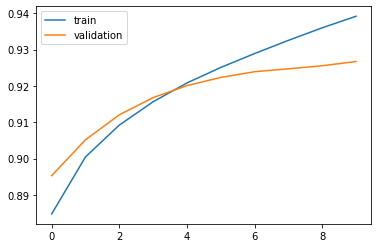

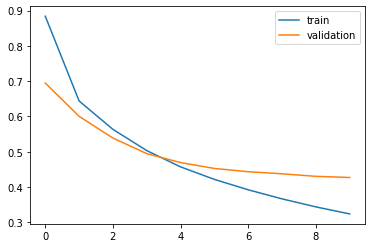

In [ ]:
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.legend(['train','validation'])
plt.show()

plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

Parece que este modelo tiene una actuación parecida primer modelo propuesto, parece que introducir la RNN bidireccional en las capas mas altas no ha influido mucho.

### Make Predictions

Cargamos el modelo para hacer predicciones

In [ ]:
model3 = load_model('model.h1_sigmoid')
preds = model3.predict_classes(testX[:1000,:].reshape((1000,testX.shape[1])))

In [ ]:
# convert predictions into text (English)
preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], eng_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
             
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t)            
        
    preds_text.append(' '.join(temp))

In [ ]:
pred_df3 = pd.DataFrame({'actual' : test[:1000,0], 'predicted' : preds_text})

In [ ]:
pd.set_option('display.max_colwidth', 200)

In [ ]:
pred_df3.head(15)

actual                                                                      predicted
0               she has forgiven him for everything            he has everything                                                  
1                         id like to have an answer    id would like have an answer                                               
2                                he is sure to come             it is that he  come                                               
3   we discovered relics of an ancient civilization             we were caught an                                                 
4                                       i am single                       im am                                                   
5           i was very tired so i went to bed early  i was very tired so i went to bed                                            
6                 he is able to speak ten languages                  he is speak                                                  
7                      you should have come earlier        you should have to  soon                                               
8                         i remember telling you so       i remember you like that                                                
9                              do you need the book               do you need the                                                 
10                    did you buy a washing machine          did you buy a machine                                                
11                       tom is very crafty isnt he            tom is a yes isnt he                                               
12                        how far is it to new york           what far is it of  new                                              
13                   may i go to the movies tonight      may i go to movies  tonight                                              
14  we have known each other since we were children      we tried the  more other we

In [ ]:
pred_df3.tail(15)

actual                                                                             predicted
985                              is tom trying to ruin our evening               tom will be to take with                                               
986                  he has lived here since he was five years old           he has been since i was years                                              
987                                                   you look hot                       you look mean                                                  
988                                look there goes a shooting star                       look at a ship                                                 
989                                i will show you around the city           ill show you around the town                                               
990                                            tom waited his turn                     tom waited turn                                                  
991                            i have to take a bus to go anywhere                 i have to take a bus by                                              
992                               i come here every fourth of july              i come here every  oclock                                               
993                          i went to the supermarket with my mom                      i went to the my                                                
994                                         is the bank open today                    is your bank open                                                 
995                           what museums would you like to visit              what else do you to visit                                               
996                              the dynamite went off with a bang                     he became with  a                                                
997                      tom said you would ask a lot of questions  tom said that would you some questions                                              
998                                      do you know when to do it                do you know how to do it                                              
999  an immense monument was erected in honor of the noble patriot          a police was  place at the   best

In [ ]:
pred_df3.sample(15)

actual                                                                         predicted
347                                my father is on the wagon       my father stopped drinking                                                 
81                        please dont insult my intelligence                  please dont my                                                  
649                         help yourself to a piece of cake           help yourself a  of cake                                               
803                                          this doesnt fit                this doesnt hurt                                                  
659                                 tom isnt as smart as you           tom isnt as smart as you                                               
368                     this lid is too tight for me to open   this coffee is too  for me i give it                                           
687                                              im freezing                          im am                                                   
620                                  i dont know what i want            i dont know what i want                                               
384  i hope i get a chance to return the favor youve done me         i wish i could you  what you                                             
350                           i asked tom about his new book          i asked tom  about his new                                              
542                                     i am a tennis player                     im a tennis                                                  
19                          who are you bringing to the play       who are you going to play the                                              
381                                      it snowed yesterday                it was yesterday                                                  
979                       did you see how big their house is  do you see the car house that house                                             
335               he has many enemies in the political world                he has many lot in

Las traducciones son mas o menos parecidas

### Cuarto modelo: probamos con RNN bidireccionales del tipo CuDNNLTSM

También probaremos a cambiar el optimizador por un Adam de lr=0.001

In [ ]:
# build NMT model
def build_final_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
    model = Sequential()
    model.add(Embedding(in_vocab, units,input_length=in_timesteps))
    model.add(Bidirectional(CuDNNLSTM(units,return_sequences=False))) # Probamos con redes recurrentes bidireccionales
    model.add(RepeatVector(out_timesteps))
    model.add(Bidirectional(CuDNNLSTM(units,return_sequences=True)))
    model.add(Dropout(0.1))
    model.add(TimeDistributed(Dense(out_vocab,activation='softmax')))
    return model

In [ ]:
model4 = build_final_model(esp_vocab_size, eng_vocab_size, esp_length, eng_length, 512)
#rms = optimizers.RMSprop(lr=0.001)
#model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')
model4.compile(loss = 'sparse_categorical_crossentropy', 
                 optimizer = optimizers.Adam(learning_rate=0.001), # Probamos con un optimizador Adam
                 metrics = ['accuracy'])

Entrenaremos el modelo.

In [ ]:
filename = 'model.h1_final'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history4 = model4.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1), 
          epochs=10, batch_size=128, 
          validation_split = 0.2,
          callbacks=[checkpoint], verbose=1)

Train on 78678 samples, validate on 19670 samples
Epoch 1/10
78678/78678 [==============================] - 155s 2ms/step - loss: 0.8947 - accuracy: 0.8842 - val_loss: 0.7725 - val_accuracy: 0.8876

Epoch 00001: val_loss improved from inf to 0.77248, saving model to model.h1_final
Epoch 2/10
78678/78678 [==============================] - 154s 2ms/step - loss: 0.7347 - accuracy: 0.8917 - val_loss: 0.7020 - val_accuracy: 0.8951

Epoch 00002: val_loss improved from 0.77248 to 0.70196, saving model to model.h1_final
Epoch 3/10
78678/78678 [==============================] - 154s 2ms/step - loss: 0.6705 - accuracy: 0.8973 - val_loss: 0.6562 - val_accuracy: 0.8995

Epoch 00003: val_loss improved from 0.70196 to 0.65616, saving model to model.h1_final
Epoch 4/10
78678/78678 [==============================] - 154s 2ms/step - loss: 0.6169 - accuracy: 0.9023 - val_loss: 0.6111 - val_accuracy: 0.9043

Epoch 00004: val_loss improved from 0.65616 to 0.61111, saving model to model.h1_final
Epoch 5/10

Comparamos la perdida en entrenamiento y validación.

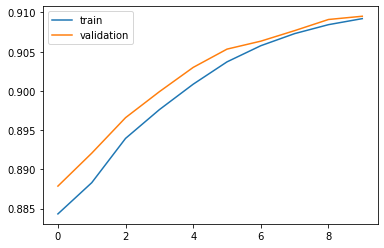

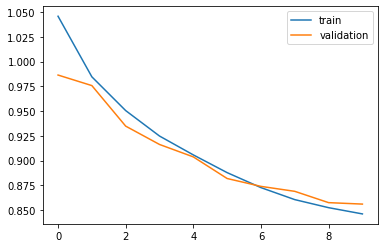

In [ ]:
plt.plot(history4.history['accuracy'])
plt.plot(history4.history['val_accuracy'])
plt.legend(['train','validation'])
plt.show()

plt.plot(history4.history['loss'])
plt.plot(history4.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

Este modelo es el que menos sobreentrena, los resultados entre entrenamiento y validación son tremendamente parecidos

### Make Predictions

Cargamos el modelo para hacer predicciones

In [ ]:
model4 = load_model('model.h1_final')
preds = model4.predict_classes(testX[:1000,:].reshape((1000,testX.shape[1])))

In [ ]:
# convert predictions into text (English)
preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], eng_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
             
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t)            
        
    preds_text.append(' '.join(temp))

In [ ]:
pred_df4 = pd.DataFrame({'actual' : test[:1000,0], 'predicted' : preds_text})

In [ ]:
pd.set_option('display.max_colwidth', 200)

In [ ]:
pred_df4.head(15)

actual                                                                   predicted
0               she has forgiven him for everything                  did was                                                   
1                         id like to have an answer         id like to have a an                                               
2                                he is sure to come         its is that he come                                                
3   we discovered relics of an ancient civilization            we had a  of  this                                              
4                                       i am single                im single                                                   
5           i was very tired so i went to bed early   i was very tired so i  to  bed                                           
6                 he is able to speak ten languages  he is to   english languages                                              
7                      you should have come earlier    you must be earlier  soon                                               
8                         i remember telling you so             i like that of                                                 
9                              do you need the book              do need  book                                                 
10                    did you buy a washing machine      did you buy a electric                                                
11                       tom is very crafty isnt he              tom is a than                                                 
12                        how far is it to new york           what time is  new                                                
13                   may i go to the movies tonight      may i go to the  tonight                                              
14  we have known each other since we were children            we were the   and

In [ ]:
pred_df4.tail(15)

actual                                                                           predicted
985                              is tom trying to ruin our evening                   i always  to be in                                               
986                  he has lived here since he was five years old       he lived to that he three years                                              
987                                                   you look hot                         you need                                                   
988                                look there goes a shooting star                       look a  star                                                 
989                                i will show you around the city                ill show to  the city                                               
990                                            tom waited his turn                   tom got my watch                                                 
991                            i have to take a bus to go anywhere                i have to take the to                                               
992                               i come here every fourth of july                  i arrived the  six                                                
993                          i went to the supermarket with my mom                   i went to with   my                                              
994                                         is the bank open today                    is the bank the                                                 
995                           what museums would you like to visit                 what do  you do to do                                              
996                              the dynamite went off with a bang                     the fox with  a                                                
997                      tom said you would ask a lot of questions  tom said he would to a some questions                                             
998                                      do you know when to do it                 do you know how i do                                               
999  an immense monument was erected in honor of the noble patriot              a  was  erected to in  the

In [ ]:
pred_df4.sample(15)

actual                                                                      predicted
775                                     tom is an adult               tom is a writer                                                 
518                             tom bought some carrots          tom bought a carrots                                                 
669                                 turn down the radio               turn  the on the                                                
113                              my wife is a good cook            my sister is a good                                                
823                             tom knows we arent busy     tom knows youre arent busy                                                
424               tom and mary are probably on vacation       tom   mary to watching the                                              
611                              what are you preparing            what are you doing                                                 
644                                      i did warn you                     they  to                                                  
892  tom ate a piece of toast and drank a cup of coffee    tom bought a piece of      his cup                                         
254                          when did you come to japan          when did you start to                                                
618                    my boss made me work last sunday  my father will me at the sunday                                              
948           my mother gave me what i wanted for lunch       my mother gave me to  help                                              
647                                 you have many books               you have  books                                                 
583                              mind your own business             do your  business                                                 
3       we discovered relics of an ancient civilization               we had a  of  this

Parece que este modelo es el que peor funciona

# Comparamos las traducciones

In [ ]:
print("Frases originales:")
print(pred_df1['actual'].head(5))
print("***************************")
print("Traducciones:")
print("***************************")
print("Modelo 1:")
print(pred_df1['predicted'].head(5))
print("Modelo 2:")
print(pred_df2['predicted'].head(5))
print("Modelo 3:")
print(pred_df3['predicted'].head(5))
print("Modelo 4:")
print(pred_df4['predicted'].head(5))

Frases originales:
0                she has forgiven him for everything
1                          id like to have an answer
2                                 he is sure to come
3    we discovered relics of an ancient civilization
4                                        i am single
Name: actual, dtype: object
***************************
Traducciones:
***************************
Modelo 1:
0       she has everything                                                  
1    id like to have a answer                                               
2     it is sure he will come                                               
3            we will into a                                                 
4               im single                                                   
Name: predicted, dtype: object
Modelo 2:
0       she has everything                                                  
1    id like to have a answer                                               
2        its is what he  com

Como podemos ver, parece que el modelo que tiene mejor actuación es el primero de todos, las traducciones se ajustan mejor. Cabe destacar que las traducciones que mejor se ajustan son aquellas en las que la frecuencia de las palabras es más alta como veíamos en la WordCloud. Los ejemplos que tienen verbos como querer, tener, I am funcionan mejor que las palabras complejas como reliquias.

In [ ]:
print("Frases originales:")
print(pred_df1['actual'].tail(5))
print("***************************")
print("Traducciones:")
print("***************************")
print("Modelo 1:")
print(pred_df1['predicted'].tail(5))
print("Modelo 2:")
print(pred_df2['predicted'].tail(5))
print("Modelo 3:")
print(pred_df3['predicted'].tail(5))
print("Modelo 4:")
print(pred_df4['predicted'].tail(5))

Frases originales:
995                             what museums would you like to visit
996                                the dynamite went off with a bang
997                        tom said you would ask a lot of questions
998                                        do you know when to do it
999    an immense monument was erected in honor of the noble patriot
Name: actual, dtype: object
***************************
Traducciones:
***************************
Modelo 1:
995           what would you  want to                                               
996                he wheres with  a                                                
997    tom said you do  some  questions                                             
998          do you know when to do it                                              
999     a great was  lived in the  of the                                           
Name: predicted, dtype: object
Modelo 2:
995             what would do you like to                     

Aquí también parece que el primer modelo es el que mejor funciona